### <b>IMDB Decision Tree Classifier</b> by [codyh587](https://github.com/codyh587)

#### Data Setup and Vectorization

In [3]:
import gc

import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay, PredefinedSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

seed = 1234
np.random.seed(seed)

In [4]:
# for low memory VMs, rerunning this may require restarting the kernel
def load_imdb_dataset(get_vectorizer=False):
    dataset = load_dataset("imdb").shuffle(seed=seed)
    vectorizer = TfidfVectorizer().fit(dataset["train"]["text"])

    train_texts = vectorizer.transform(dataset["train"]["text"])
    train_labels = np.array(dataset["train"]["label"])

    test_texts = vectorizer.transform(dataset["test"]["text"])
    test_labels = np.array(dataset["test"]["label"])

    del dataset
    if not get_vectorizer:
        del vectorizer

    gc.collect()

    train_texts, valid_texts, train_labels, valid_labels = train_test_split(
        train_texts,
        train_labels,
        test_size=0.25,
        random_state=seed,
        stratify=train_labels
    )

    return (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels
    ) if not get_vectorizer else (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels,
        vectorizer
    )

In [5]:
# labels: 0 = negative review, 1 = positive review
train_X, train_y, valid_X, valid_y, test_X, test_y = load_imdb_dataset()

In [24]:
print(f"Train texts shape: {train_X.shape}")
print(f"Train labels shape: {train_y.shape}")
print(f"Valid texts shape: {valid_X.shape}")
print(f"Valid labels shape: {valid_y.shape}")
print(f"Test texts shape: {test_X.shape}")
print(f"Test labels shape: {test_y.shape}")

Train texts shape: (18750, 74849)
Train labels shape: (18750,)
Valid texts shape: (6250, 74849)
Valid labels shape: (6250,)
Test texts shape: (25000, 74849)
Test labels shape: (25000,)


#### Finding Optimal Depth

In [11]:
depths = [i for i in range(1, 21)]
depth_train_errors = []
depth_valid_errors = []

def calculate_errors():
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        depth_train_errors.append(1 - accuracy_score(train_y, train_pred))
        depth_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

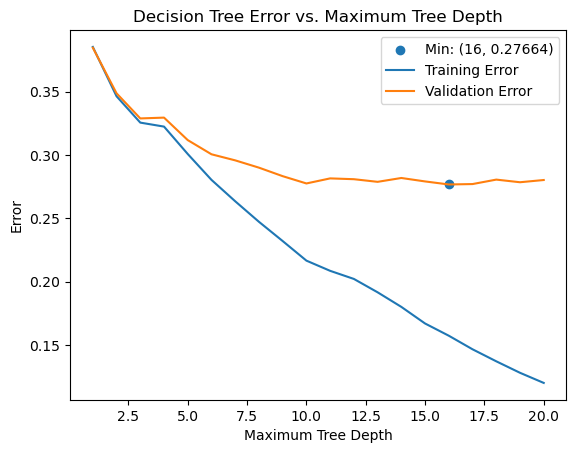

In [13]:
def plot_errors():
    min_index = np.argmin(depth_valid_errors)
    min_depth = depths[min_index]
    min_error = depth_valid_errors[min_index]

    plt.scatter(min_depth, min_error, label=f"Min: ({min_depth}, {min_error})")
    plt.plot(depths, depth_train_errors, label="Training Error")
    plt.plot(depths, depth_valid_errors, label="Validation Error")
    plt.title("Decision Tree Error vs. Maximum Tree Depth")
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_errors()

#### Finding Optimal Criterion

In [28]:
criterions = ["gini", "entropy", "log_loss"]
criterion_train_errors = []
criterion_valid_errors = []

def calculate_errors():
    for criterion in criterions:
        clf = DecisionTreeClassifier(max_depth=16, criterion=criterion, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        criterion_train_errors.append(1 - accuracy_score(train_y, train_pred))
        criterion_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

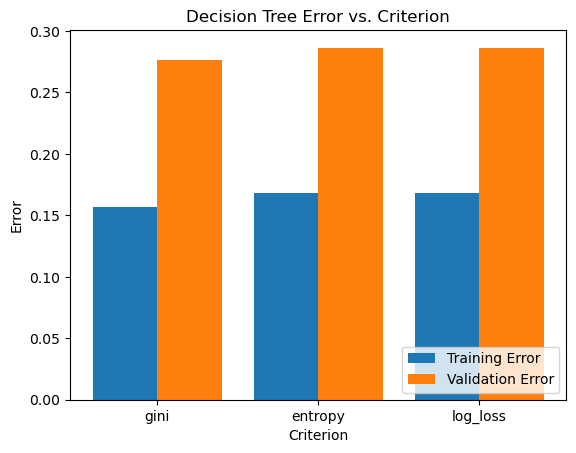

In [29]:
def plot_errors():
    width = 0.4
    x = np.arange(len(criterions))
    plt.bar(x - width / 2, criterion_train_errors, width, label="Training Error")
    plt.bar(x + width / 2, criterion_valid_errors, width, label="Validation Error")
    plt.title("Decision Tree Error vs. Criterion")
    plt.xlabel("Criterion")
    plt.ylabel("Error")
    plt.xticks(x, criterions)
    plt.legend(loc="lower right")
    plt.show()

plot_errors()

#### Finding Optimal Min Split Samples

In [30]:
minsplits = [i for i in range(2, 21)]
minsplit_train_errors = []
minsplit_valid_errors = []

def calculate_errors():
    for minsplit in minsplits:
        clf = DecisionTreeClassifier(max_depth=16, min_samples_split=minsplit, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        minsplit_train_errors.append(1 - accuracy_score(train_y, train_pred))
        minsplit_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

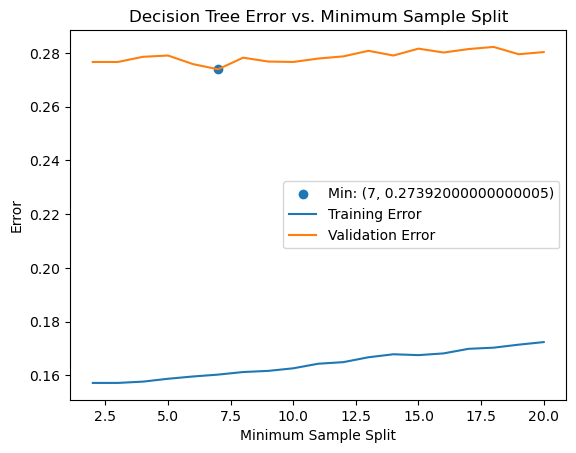

In [31]:
def plot_errors():
    min_index = np.argmin(minsplit_valid_errors)
    min_split = minsplits[min_index]
    min_error = minsplit_valid_errors[min_index]

    plt.scatter(min_split, min_error, label=f"Min: ({min_split}, {min_error})")
    plt.plot(minsplits, minsplit_train_errors, label="Training Error")
    plt.plot(minsplits, minsplit_valid_errors, label="Validation Error")
    plt.title("Decision Tree Error vs. Minimum Sample Split")
    plt.xlabel("Minimum Sample Split")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_errors()

#### Finding Optimal Min Leaf Samples

In [33]:
minsamples = [i for i in range(1, 21)]
minsample_train_errors = []
minsample_valid_errors = []

def calculate_errors():
    for minsample in minsamples:
        clf = DecisionTreeClassifier(max_depth=16, min_samples_leaf=minsample, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        minsample_train_errors.append(1 - accuracy_score(train_y, train_pred))
        minsample_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

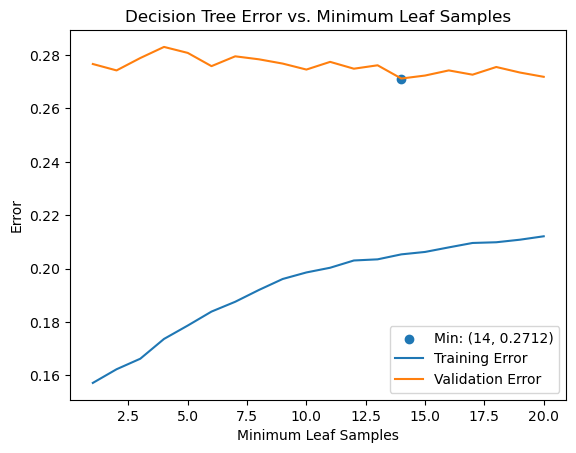

In [34]:
def plot_errors():
    min_index = np.argmin(minsample_valid_errors)
    min_sample = minsamples[min_index]
    min_error = minsample_valid_errors[min_index]

    plt.scatter(min_sample, min_error, label=f"Min: ({min_sample}, {min_error})")
    plt.plot(minsamples, minsample_train_errors, label="Training Error")
    plt.plot(minsamples, minsample_valid_errors, label="Validation Error")
    plt.title("Decision Tree Error vs. Minimum Leaf Samples")
    plt.xlabel("Minimum Leaf Samples")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_errors()

#### Finding Optimal Hyperparams with Heuristic Grid Search

In [11]:
def calculate_optimal_params():
    param_grid = {
        "max_depth": [i for i in range(1, 21)] + [None],
        "min_samples_split": [i for i in range(2, 11)],
        "min_samples_leaf": [i for i in range(1, 21)],
    }

    X_combined = sparse.vstack([train_X, valid_X])
    y_combined = np.concatenate([train_y, valid_y])

    test_fold = np.zeros(train_y.shape[0] + valid_y.shape[0])
    test_fold[:train_y.shape[0]] = -1

    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=seed),
        param_grid,
        cv=PredefinedSplit(test_fold),
        n_jobs=-1
    )

    grid_search.fit(X_combined, y_combined)
    return grid_search


In [12]:
grid_search = calculate_optimal_params()

#### Testing Grid Search vs. Individual Hyperparams (Set Seed)

In [ ]:
# grid_search = DecisionTreeClassifier(max_depth=19, min_samples_split=14, min_samples_leaf=2, random_state=seed)
grid_search_error = 1 - grid_search.best_estimator_.score(test_X, test_y)
print("Grid Search Params:", grid_search.best_params_)
print("Grid Search Test Error:", grid_search_error)

Grid Search Params: {'max_depth': 19, 'min_samples_leaf': 14, 'min_samples_split': 2}
Grid Search Test Error: 0.27436000000000005


In [14]:
individual = DecisionTreeClassifier(max_depth=16, min_samples_split=7, min_samples_leaf=14, random_state=seed)
individual.fit(train_X, train_y)
individual_error = 1 - individual.score(test_X, test_y)
print("Individual Params:", {"max_depth": 16, "min_samples_split": 7, "min_samples_leaf": 14})
print("Individual Test Error:", individual_error)

Individual Params: {'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 14}
Individual Test Error: 0.26712


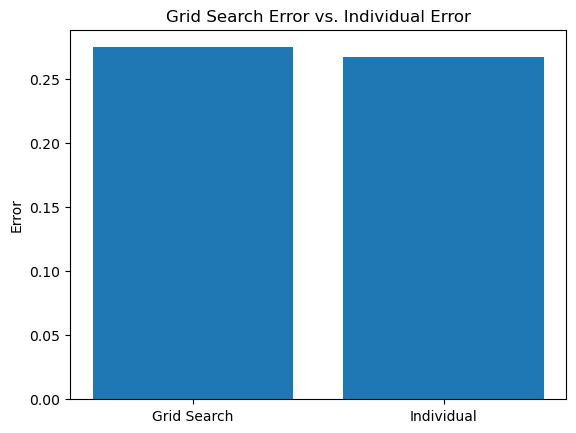

In [15]:
def plot_errors():
    plt.bar(["Grid Search", "Individual"], [grid_search_error, individual_error])
    plt.title("Grid Search Error vs. Individual Error")
    plt.ylabel("Error")
    plt.show()

plot_errors()

#### Testing Grid Search vs. Individual Hyperparams (Random Seed)

In [49]:
def calculate_errors():
    seed = None
    np.random.seed(seed)
    train_X, train_y, valid_X, valid_y, test_X, test_y, vectorizer = load_imdb_dataset(get_vectorizer=True)

    grid_search = DecisionTreeClassifier(max_depth=19, min_samples_split=2, min_samples_leaf=14)
    grid_search.fit(train_X, train_y)
    grid_search_error = 1 - grid_search.score(test_X, test_y)
    print("Grid Search Test Error:", grid_search_error)

    individual = DecisionTreeClassifier(max_depth=16, min_samples_split=7, min_samples_leaf=14)
    individual.fit(train_X, train_y)
    individual_error = 1 - individual.score(test_X, test_y)
    print("Individual Test Error:", individual_error)

    plt.bar(["Grid Search", "Individual"], [grid_search_error, individual_error])
    plt.title("Grid Search Error vs. Individual Error")
    plt.ylabel("Error")
    plt.show()

    return grid_search, individual, vectorizer

Grid Search Test Error: 0.26292000000000004
Individual Test Error: 0.26808


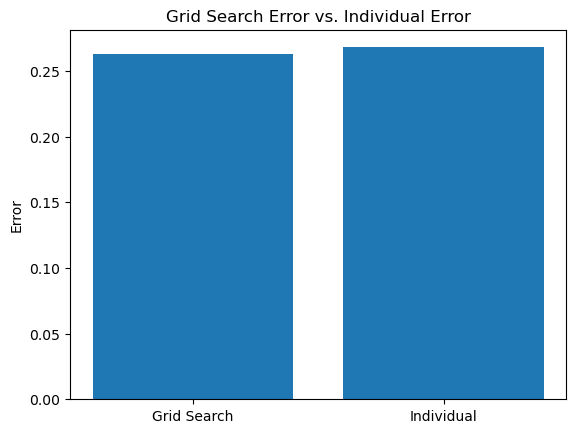

In [50]:
grid_search, individual, vectorizer = calculate_errors()

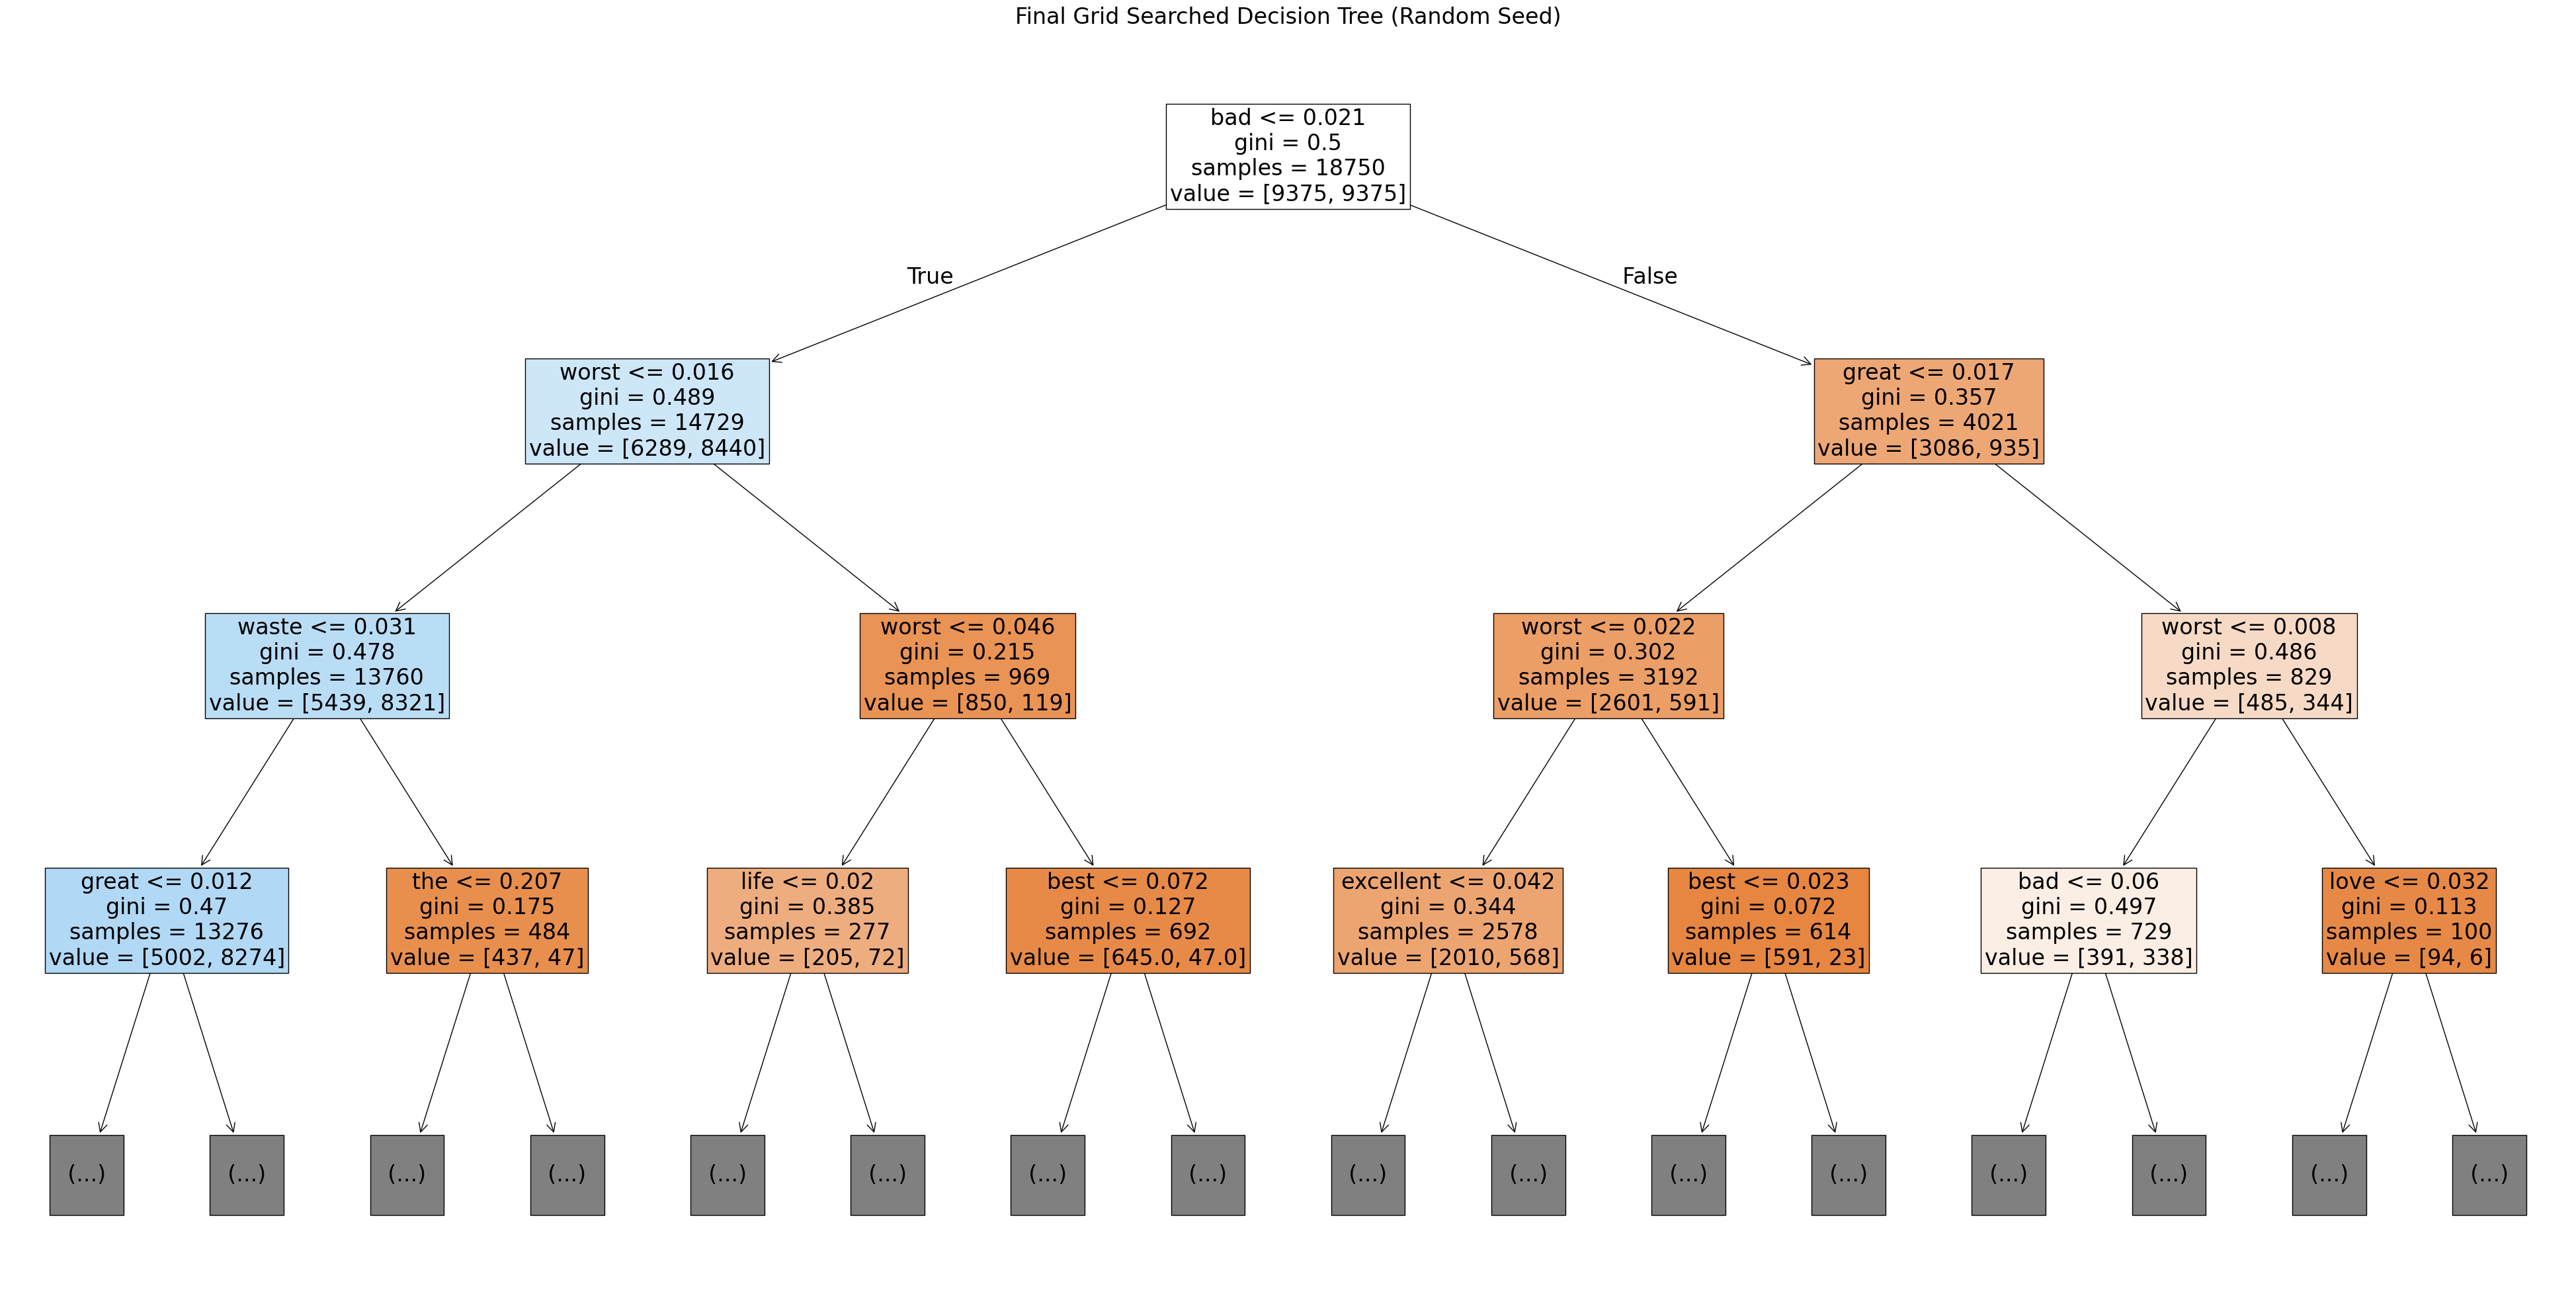

In [53]:
plt.figure(figsize=(50, 25))
plot_tree(grid_search, feature_names=vectorizer.get_feature_names_out(), max_depth=3, filled=True, fontsize=24)
plt.title("Final Grid Searched Decision Tree (Random Seed)", fontsize=24)
plt.show()

#### Learning Curve Display

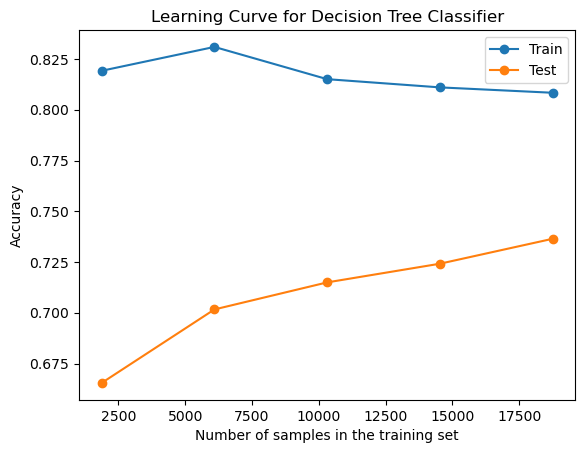

In [6]:
def calculate_learning_class():
    X_combined = sparse.vstack([train_X, test_X])
    y_combined = np.concatenate([train_y, test_y])

    test_fold = np.zeros(train_y.shape[0] + test_y.shape[0])
    test_fold[:train_y.shape[0]] = -1

    common_params = {
        "X": X_combined,
        "y": y_combined,
        "cv": PredefinedSplit(test_fold),
        "score_type": "both",
        "n_jobs": -1,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }

    grid_search = DecisionTreeClassifier(max_depth=19, min_samples_split=2, min_samples_leaf=14)
    LearningCurveDisplay.from_estimator(grid_search, **common_params).ax_.set_title("Learning Curve for Decision Tree Classifier")

calculate_learning_class()

#### Confusion Matrix

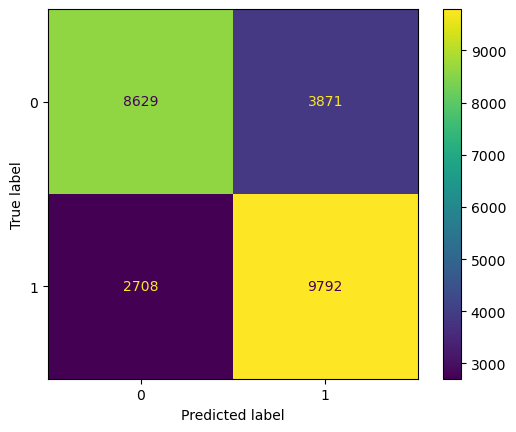

In [9]:
def calculate_confusion_matrix():
    grid_search = DecisionTreeClassifier(max_depth=19, min_samples_split=2, min_samples_leaf=14)
    grid_search.fit(train_X, train_y)
    cf_display = ConfusionMatrixDisplay.from_estimator(grid_search, test_X, test_y, values_format='d')

calculate_confusion_matrix()
